<a href="https://colab.research.google.com/github/Umarsmuhammed/Arewa_DeepLearning/blob/main/Week_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyTorch Workflow: Week two Assignment**

In [3]:
# First we import required libraries
import torch
import matplotlib.pyplot as plt
from torch import nn

# We then Set up device-agnostic code

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

1.

**Step 1:** We create a straight line dataset using the linear regression formula (weight * X + bias), by setting weight=0.3 and bias=0.9

In [5]:
# Create *known* parameters
weight = 0.3
bias = 0.9

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(0, 1, 0.01).unsqueeze(dim=1)
y = weight * X + bias

print(f"Number of X samples: {len(X)}")
print(f"Number of y samples: {len(y)}")
print(f"First 10 X & y samples:\nX: {X[:10]}\ny: {y[:10]}")

Number of X samples: 100
Number of y samples: 100
First 10 X & y samples:
X: tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]])
y: tensor([[0.9000],
        [0.9030],
        [0.9060],
        [0.9090],
        [0.9120],
        [0.9150],
        [0.9180],
        [0.9210],
        [0.9240],
        [0.9270]])


**Step 2:** Split the data into 80% training, 20% testing.
Plot the training and testing data so it becomes visual.

In [6]:
# Split the data into training and testing
train_split = int(len(X) * 0.8) # Out total 100 datapoints, we split the data into 80% training, 20% testing.
X_train = X[:train_split]
y_train = y[:train_split]
X_test = X[train_split:]
y_test = y[train_split:]
len(X_train),len(y_train),len(X_test),len(y_test)

(80, 80, 20, 20)

**Step 3:** Plot the training and testing data

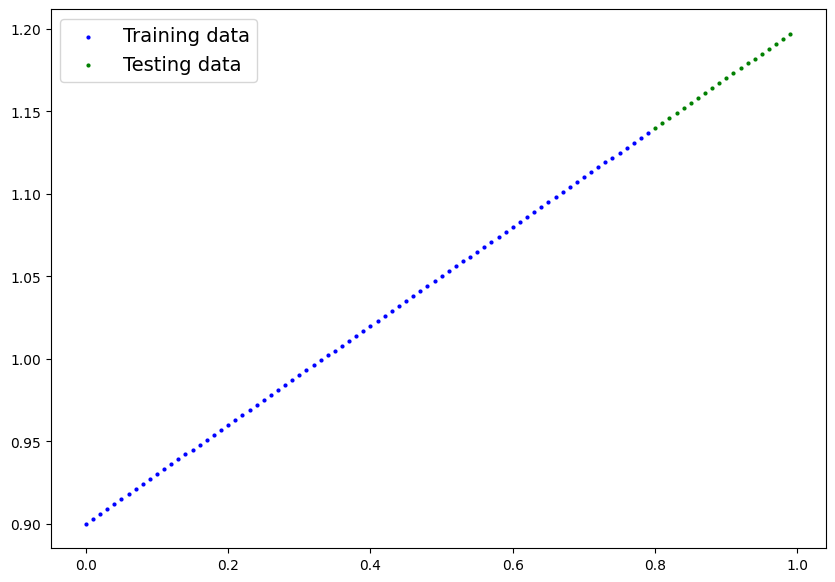

In [7]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});
plot_predictions()

2. Build a PyTorch model by subclassing nn.Module.
Let's replicate a standard linear regression model using pure PyTorch.

In [9]:
# Create PyTorch linear regression model by subclassing nn.Module
## Option 1
#class LinearRegressionModel(nn.Module):
 # def __init__(self):
  #  super().__init__()
   # self.weight = nn.Parameter(data=torch.randn(1,
    ##                                         dtype=torch.float
      #                                        ))
    #f.bias = nn.Parameter(data=torch.randn(1,
     #                                         requires_grad=True,
      #                                        dtype=torch.float
       #                                       ))

  #def forward(self, x):
   # return self.weight * x + self.bias

# ## Option 2
class LinearRegressionModel(nn.Module):
   def __init__(self):
     super().__init__()
     self.linear_layer = nn.Linear(in_features = 1,
                                   out_features = 1)
   def forward(self,x : torch.Tensor) -> torch.Tensor:  # <- "x" is the input data (e.g. training/testing features)
     return self.linear_layer(x)  # <- this is the linear regression formula (y = m*x + b)

Checking the contents of a PyTorch model

In [11]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(40)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_1 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_1.parameters())

torch.manual_seed(40)
model_1 = LinearRegressionModel()
model_1,model_1.state_dict()

(LinearRegressionModel(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[-0.2642]])),
              ('linear_layer.bias', tensor([0.7322]))]))

#3. Create a loss function and optimizer using nn.L1Loss() and torch.optim.SGD(params, lr) respectively.

In [13]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate

Let's put all of the above together and train our model for 100 epochs (forward passes through the data) and we'll evaluate it every 10 epochs.

In [14]:
torch.manual_seed(40)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 300

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_1.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_1(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_1.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_1(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 20 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.3906722664833069 | MAE Test Loss: 0.6592587232589722 
Epoch: 20 | MAE Train Loss: 0.16442446410655975 | MAE Test Loss: 0.3926299214363098 
Epoch: 40 | MAE Train Loss: 0.08731291443109512 | MAE Test Loss: 0.23980149626731873 
Epoch: 60 | MAE Train Loss: 0.07414168119430542 | MAE Test Loss: 0.1830405443906784 
Epoch: 80 | MAE Train Loss: 0.06695624440908432 | MAE Test Loss: 0.15779133141040802 
Epoch: 100 | MAE Train Loss: 0.060096271336078644 | MAE Test Loss: 0.14111869037151337 
Epoch: 120 | MAE Train Loss: 0.053244449198246 | MAE Test Loss: 0.1251339167356491 
Epoch: 140 | MAE Train Loss: 0.04639333486557007 | MAE Test Loss: 0.1088055819272995 
Epoch: 160 | MAE Train Loss: 0.039541762322187424 | MAE Test Loss: 0.09247813373804092 
Epoch: 180 | MAE Train Loss: 0.03268999233841896 | MAE Test Loss: 0.07649458944797516 
Epoch: 200 | MAE Train Loss: 0.02583879604935646 | MAE Test Loss: 0.06016702204942703 
Epoch: 220 | MAE Train Loss: 0.01898711919784546 | MAE 

# 4. Make predictions with the trained model on the test data.
  - Making predictions using torch.inference_mode()

In [15]:
# Make predictions with the model
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)
y_preds

tensor([[1.1403],
        [1.1433],
        [1.1462],
        [1.1492],
        [1.1521],
        [1.1551],
        [1.1580],
        [1.1610],
        [1.1639],
        [1.1669],
        [1.1698],
        [1.1728],
        [1.1757],
        [1.1786],
        [1.1816],
        [1.1845],
        [1.1875],
        [1.1904],
        [1.1934],
        [1.1963]])

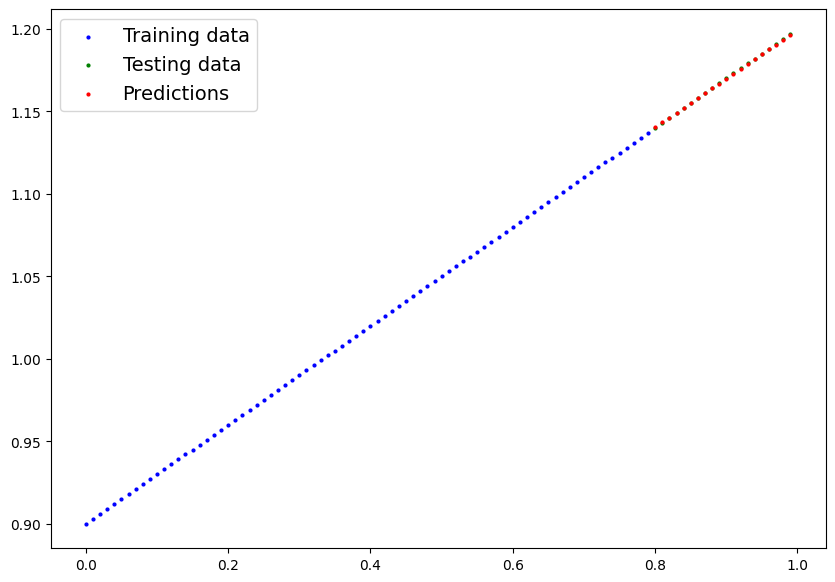

In [16]:
# Plot predictions
plot_predictions(predictions=y_preds)

#5. Save your trained model's state_dict() to file.
- Create a new instance of your model class you made in 2. and load in the state_dict() you just saved to it.
- Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [17]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents = True,exist_ok = True)
# 2. Create model save path
MODEL_NAME = "pytorch_fundamental"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
# 3. Save the model state dict
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj = model_1.state_dict(),f = MODEL_SAVE_PATH)

Saving model to models/pytorch_fundamental


In [18]:
# Create new instance of model and load saved state dict (make sure to put it on the target device)
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(f = MODEL_SAVE_PATH))
loaded_model.to(device)


LinearRegressionModel(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [19]:
# Make predictions with loaded model and compare them to the previous
y_preds_new = loaded_model(X_test)
y_preds == y_preds_new


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

In [20]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.2948]])),
             ('linear_layer.bias', tensor([0.9045]))])